In [ ]:
import pandas as pd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import *
import requests
from sklearn.metrics import *
import warnings
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch.optim as optim
warnings.filterwarnings('ignore')

In [ ]:
KEY = "98464488-2db9-4ddc-9b98-6b48f8b623dc" # do not change
LIMIT = 365
COIN = 'BTC'

In [ ]:
def prices(product_id, period=30, granularity=86400, start=None, end=None):
    """
    Fetch historical candlestick data for a cryptocurrency pair from now to the specified number of days in the past.

    :param product_id: The product ID for the crypto pair (e.g., 'BTC-USD').
    :param period: Number of days of historical data to fetch.
    :param granularity: Desired time slice in seconds (60, 300, 900, 3600, 21600, 86400).
    :return: DataFrame containing historical data.
    """
    if not product_id.endswith('-USD'):
        product_id += '-USD'
    product_id = product_id.upper()
    url = f"https://api.exchange.coinbase.com/products/{product_id}/candles"
    if start is None and end is None: # get data from specified number of days ago if date bounds are not specified.
        end = datetime.now()
        start = end - timedelta(days=period)
    coin = product_id.split('-')[0]
    all_data = []

    while start < end:
        end_slice = min(start + timedelta(seconds=granularity * 300), end)
        params = {
            'start': start.isoformat(),
            'end': end_slice.isoformat(),
            'granularity': granularity
        }

        try:
            response = requests.get(url, params=params)
        except ConnectionError:
            print("No internet connection")
            return None, coin
        except ReadTimeoutError:
            print('Your wifi likely doesn\'t allow to access Coinbase API')
            return None, coin

        if response.status_code == 200:
            data = response.json()
            all_data.extend(data)
        else:
            print("Failed to fetch data:", response.text)
            break

        start = end_slice

    if all_data:
        columns = ['time', 'low', 'high', 'open', 'close', 'volume']
        data = pd.DataFrame(all_data, columns=columns)
        data['time'] = pd.to_datetime(data['time'], unit='s')
        data['change'] = data['close'] - data['open']
        data['pct_change'] = (data['change'] / data['open']) * 100
        return data, coin
    return None, coin

In [ ]:
df, coin = prices(COIN, period=365)

In [ ]:
df

,time,low,high,open,close,volume,change,pct_change
0,2024-12-23,92360.91,96430.08,95091.15,94764.56,13476.989476,-326.59,-0.343449
1,2024-12-22,94182.98,97387.98,97230.09,95087.75,4933.501277,-2142.34,-2.203371
2,2024-12-21,96368.00,99596.57,97762.75,97230.08,6451.432714,-532.67,-0.544860
3,2024-12-20,92115.66,98132.47,97372.20,97765.00,21766.623861,392.80,0.403401
4,2024-12-19,95539.67,102796.22,100148.60,97372.21,23522.128639,-2776.39,-2.772270
...,...,...,...,...,...,...,...,...
360,2024-12-28,94002.72,95534.17,94171.70,95130.82,2722.659136,959.12,1.018480
361,2024-12-27,93234.31,97340.47,95669.40,94171.89,13169.128976,-1497.51,-1.565297
362,2024-12-26,95083.93,99887.00,99358.67,95669.49,11403.372689,-3689.18,-3.712993
363,2024-12-25,97557.48,99484.92,98594.47,99346.28,5254.237060,751.81,0.762528


## Find the FGI change and close price change correlation

Do this for all the coins

In [ ]:
def get_fgi_data():
  url = f'https://pro-api.coinmarketcap.com/v3/fear-and-greed/historical?CMC_PRO_API_KEY={KEY}&limit={LIMIT}'
  json = requests.get(url)
  if json.status_code == 200:
      data = json.json()
      fgi_df = pd.DataFrame(data['data'])
      fgi_df['timestamp'] = pd.to_datetime(fgi_df['timestamp'], unit='s')
      return fgi_df
  else:
    print("Couldn\'t get FGI data with status code" + str(json.status_code))
    return None

In [ ]:
def fgi_close_association(coin='BTC'):
  try:
    coinPrices, i = prices(coin, period=LIMIT)
  except:
    print('Invalid coin: ', coin)
    print('Period: ', LIMIT)
    return None
  url = f'https://pro-api.coinmarketcap.com/v3/fear-and-greed/historical?CMC_PRO_API_KEY={KEY}&limit={LIMIT}'
  json = requests.get(url)
  if json.status_code == 200:
      data = json.json()
      fgi_df = pd.DataFrame(data['data'])
  else:
    print("Couldn\'t get FGI data with status code" + str(json.status_code))
    return None

  # convert timestamp to date
  fgi_df['timestamp'] = pd.to_datetime(fgi_df['timestamp'], unit='s')

  # inner join the prices on the timestamp
  everything = pd.merge(coinPrices, fgi_df, left_on='time', right_on='timestamp', how='inner')
  everything = pd.get_dummies(everything)

  # create pct_change for the fgi value
  everything['fgi_pct_change'] = everything['value'].pct_change()
  everything['fgi_pct_change'].fillna(0, inplace=True)
  everything['pct_change'].fillna(0, inplace=True)
  correlation = everything.corr()
  item1 = correlation['pct_change']['fgi_pct_change']
  item2 = np.sqrt(mean_squared_error(everything['pct_change'], everything['fgi_pct_change']))
  return {
      'coin': coin,
      'correlation': item1,
      'RMSE': item2
  }

In [ ]:
coins = ['BTC', 'NEAR', 'ETH', 'AVAX', 'SOL', 'ICP', 'FET']
correlations = [fgi_close_association(coin) for coin in coins]
everything = pd.DataFrame(correlations).sort_values(by='RMSE', ascending=True)

In [ ]:
import altair as alt

# Sort the DataFrame by RMSE in ascending order
everything_sorted = everything.sort_values('RMSE')

# Create the bar plot
alt.Chart(everything_sorted).mark_bar().encode(
    x=alt.X('coin', sort= 'y'),  # Sort x-axis (coins) by y-axis (RMSE)
    y='RMSE'
).properties(
    title='RMSE by Coin'  # Add a title to the chart
)

alt.Chart(...)

In [ ]:
# Sort the DataFrame by RMSE in ascending order
everything_sorted = everything.sort_values('correlation')
everything_sorted['abs_correlation'] = np.abs(everything_sorted['correlation'])

# Create the bar plot
alt.Chart(everything_sorted).mark_bar().encode(
    x=alt.X('coin', sort= 'y'),  # Sort x-axis (coins) by y-axis (RMSE)
    y='abs_correlation'
).properties(
    title='Correlation Magnitude by Coin'  # Add a title to the chart
)

alt.Chart(...)

## Crypto market collector

In [ ]:
import requests
import pandas as pd
from datetime import datetime, timedelta

# Constants

# -------------------------------
# 1. Market-Faceted Metrics
# -------------------------------

def get_global_market_data():
    """
    Fetch overall market data such as total market capitalization, trading volume, and Bitcoin dominance.
    Purpose: Helps understand the overall health and activity of the cryptocurrency market.
    """
    url = f"https://pro-api.coinmarketcap.com/v1/global-metrics/quotes/latest"
    headers = {
        'X-CMC_PRO_API_KEY': KEY
    }
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        data = response.json()
        return {
            'total_market_cap': data['data']['quote']['USD']['total_market_cap'],
            'total_volume_24h': data['data']['quote']['USD']['total_volume_24h'],
            'btc_dominance': data['data']['btc_dominance'],
            'active_cryptocurrencies': data['data']['active_cryptocurrencies']
        }
    else:
        print(f"Failed to fetch global market data: {response.status_code}")
        return None

def get_tokenomics(coin):
    """
    Fetch tokenomics data such as circulating supply and total supply.
    Purpose: Helps understand the supply dynamics of a coin, which can influence its price.
    """
    url = f"https://pro-api.coinmarketcap.com/v1/cryptocurrency/info"
    headers = {
        'X-CMC_PRO_API_KEY': KEY
    }
    params = {
        'symbol': coin
    }
    response = requests.get(url, headers=headers, params=params)
    if response.status_code == 200:
        data = response.json()
        supply_data = data['data'][coin]
        return supply_data
    else:
        print(f"Failed to fetch tokenomics for {coin}: {response.status_code}")
        return None

# -------------------------------
# Additional Metrics
# -------------------------------


# Example Usage
if __name__ == "__main__":
    # Fetch global market data
    market_data = get_global_market_data()
    print("Market Data:", market_data)

    # Fetch tokenomics data
    tokenomics_data = get_tokenomics('BTC')
    print("Tokenomics:", tokenomics_data)


Market Data: {'total_market_cap': 2757929684737.189, 'total_volume_24h': 133605753001.2, 'btc_dominance': 60.414822612629, 'active_cryptocurrencies': 10891}
Tokenomics: {'id': 1, 'name': 'Bitcoin', 'symbol': 'BTC', 'category': 'coin', 'description': 'Bitcoin (BTC) is a cryptocurrency launched in 2010. Users are able to generate BTC through the process of mining. Bitcoin has a current supply of 19,829,468. The last known price of Bitcoin is 84,084.66159273 USD and is down -3.28 over the last 24 hours. It is currently trading on 11960 active market(s) with $56,873,865,949.33 traded over the last 24 hours. More information can be found at https://bitcoin.org/.', 'slug': 'bitcoin', 'logo': 'https://s2.coinmarketcap.com/static/img/coins/64x64/1.png', 'subreddit': 'bitcoin', 'notice': '', 'tags': ['mineable', 'pow', 'sha-256', 'store-of-value', 'state-channel', 'coinbase-ventures-portfolio', 'three-arrows-capital-portfolio', 'polychain-capital-portfolio', 'binance-labs-portfolio', 'blockchai

In [ ]:
pd.json_normalize(tokenomics_data)

,id,name,symbol,category,description,slug,logo,subreddit,notice,tags,...,urls.website,urls.twitter,urls.message_board,urls.chat,urls.facebook,urls.explorer,urls.reddit,urls.technical_doc,urls.source_code,urls.announcement
0,1,Bitcoin,BTC,coin,Bitcoin (BTC) is a cryptocurrency launched in ...,bitcoin,https://s2.coinmarketcap.com/static/img/coins/...,bitcoin,,"[mineable, pow, sha-256, store-of-value, state...",...,[https://bitcoin.org/],[],[https://bitcointalk.org],[],[],"[https://blockchain.info/, https://live.blockc...",[https://reddit.com/r/bitcoin],[https://bitcoin.org/bitcoin.pdf],[https://github.com/bitcoin/bitcoin],[]


In [ ]:
pd.json_normalize(market_data)

,total_market_cap,total_volume_24h,btc_dominance,active_cryptocurrencies
0,2.757930e+12,1.336058e+11,60.414823,10891


# Steps to train LSTM to predict buy and sell



1.   Obtain additional metrics

* Moving averages (short-term and long-term)
* Relative Strength Index (RSI)
* Moving Average Convergence Divergence (MACD)
* Bollinger Bands
* Volume indicators

2.   Model Approaches

* Classification
  * label buys, sells, holds (1, -1, 0) based on market data
  * predict each label

* Regression
  * predict return over time
    * look at windows of time to find optimal profits
  * identify buy and sell periods



### Generate Metrics

In [ ]:
import pandas as pd
import numpy as np

# Assume you have already fetched data using your prices() function,
# and that your DataFrame (df) has at least the following columns:
# ['time', 'low', 'high', 'open', 'close', 'volume']

# ----------------------------
# 1. Moving Averages (SMA & EMA)
# ----------------------------
# Short-term SMA (20 periods) and long-term SMA (50 periods)
df['SMA_20'] = df['close'].rolling(window=20).mean()
df['SMA_50'] = df['close'].rolling(window=50).mean()

# Exponential Moving Averages (optional, can be used in place of or along with SMAs)
df['EMA_20'] = df['close'].ewm(span=20, adjust=False).mean()
df['EMA_50'] = df['close'].ewm(span=50, adjust=False).mean()

# ----------------------------
# 2. Relative Strength Index (RSI)
# ----------------------------
def compute_rsi(series, window=14):
    delta = series.diff()
    # Separate positive and negative gains
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)

    # Simple moving average over 'window' periods for gains/losses
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()

    # Alternatively, one can use exponential weighting:
    # avg_gain = gain.ewm(alpha=1/window, min_periods=window, adjust=False).mean()
    # avg_loss = loss.ewm(alpha=1/window, min_periods=window, adjust=False).mean()

    rs = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

df['RSI'] = compute_rsi(df['close'], window=14)

# ----------------------------
# 3. Moving Average Convergence Divergence (MACD)
# ----------------------------
# Calculate the 12-period and 26-period EMA of the closing price
df['EMA_12'] = df['close'].ewm(span=12, adjust=False).mean()
df['EMA_26'] = df['close'].ewm(span=26, adjust=False).mean()

# MACD line: difference between the 12-EMA and 26-EMA
df['MACD'] = df['EMA_12'] - df['EMA_26']

# Signal line: 9-period EMA of the MACD line
df['MACD_Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()

# MACD Histogram: the difference between MACD and its signal line
df['MACD_Hist'] = df['MACD'] - df['MACD_Signal']

# ----------------------------
# 4. Bollinger Bands
# ----------------------------
# Bollinger Bands are typically computed using a moving average and standard deviation.
# Here we use the 20-period SMA (which we already computed) and a factor of 2 standard deviations.
df['BB_Middle'] = df['SMA_20']  # Middle band is the 20-period SMA
df['BB_STD'] = df['close'].rolling(window=20).std()
df['BB_Upper'] = df['BB_Middle'] + 2 * df['BB_STD']
df['BB_Lower'] = df['BB_Middle'] - 2 * df['BB_STD']

# Optionally, you can drop the intermediate 'BB_STD' column later if not needed:
# df.drop(columns=['BB_STD'], inplace=True)

# ----------------------------
# 5. Volume Indicators
# ----------------------------
# Example 1: 20-period moving average of volume (helps smooth out spikes)
df['Volume_MA_20'] = df['volume'].rolling(window=20).mean()

# Example 2: On-Balance Volume (OBV)
# OBV is designed to relate volume flow to price change.
# We'll start OBV at zero and add/subtract volume depending on price movement.
df['daily_return'] = df['close'].pct_change()  # percentage change in closing price
df['direction'] = np.where(df['daily_return'] > 0, 1, -1)  # +1 for up days, -1 for down days
df.loc[df['daily_return'].isna(), 'direction'] = 0  # set initial value to 0
df['OBV'] = (df['volume'] * df['direction']).fillna(0).cumsum()

# Clean up temporary columns
df.drop(columns=['daily_return', 'direction'], inplace=True)

# ----------------------------
# View the final DataFrame with the newly computed technical indicators
# ----------------------------
df.tail()

# If you wish to inspect or plot these indicators (for example, overlaying Bollinger Bands on price),
# you can use matplotlib, seaborn, or a plotting library of your choice.

,time,low,high,open,close,volume,change,pct_change,SMA_20,SMA_50,...,EMA_26,MACD,MACD_Signal,MACD_Hist,BB_Middle,BB_STD,BB_Upper,BB_Lower,Volume_MA_20,OBV
360,2024-12-28,94002.72,95534.17,94171.70,95130.82,2722.659136,959.12,1.018480,96138.1135,98757.4792,...,96704.747594,-1136.513219,-725.696536,-410.816683,96138.1135,2723.733156,101585.579813,90690.647187,9342.954236,-136781.756471
361,2024-12-27,93234.31,97340.47,95669.40,94171.89,13169.128976,-1497.51,-1.565297,95847.6190,98688.9782,...,96517.128513,-1163.716350,-813.300499,-350.415851,95847.6190,2599.192642,101046.004285,90649.233715,9385.792001,-149950.885447
362,2024-12-26,95083.93,99887.00,99358.67,95669.49,11403.372689,-3689.18,-3.712993,95605.5820,98652.1874,...,96454.340475,-1052.300952,-861.100590,-191.200363,95605.5820,2356.183308,100317.948617,90893.215383,9275.911450,-138547.512758
363,2024-12-25,97557.48,99484.92,98594.47,99346.28,5254.237060,751.81,0.762528,95746.1480,98706.6072,...,96668.558217,-659.712468,-820.822965,161.110498,95746.1480,2494.354657,100734.857313,90757.438687,8978.086737,-133293.275698
364,2024-12-24,93426.25,99444.00,94767.88,98594.47,13355.363143,3826.59,4.037855,95950.5490,98721.2460,...,96811.218350,-404.584253,-737.575223,332.990969,95950.5490,2554.199737,101058.948474,90842.149526,8991.111714,-146648.638841


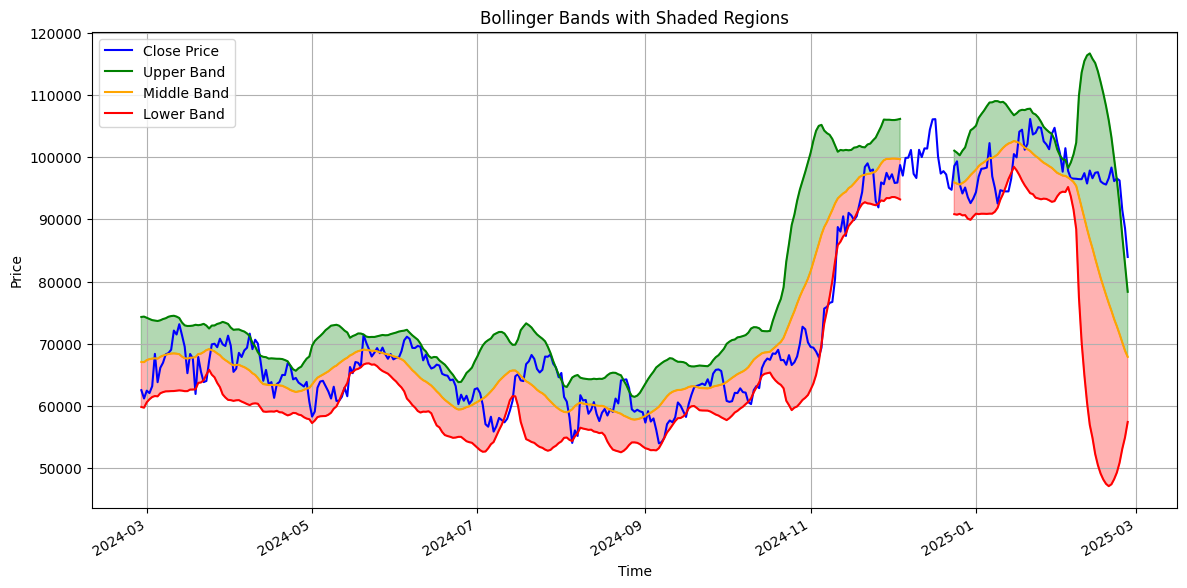

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Ensure the DataFrame is sorted by time
df = df.sort_values('time').reset_index(drop=True)

# Optionally drop rows with NaNs in Bollinger Bands, if any (depends on your data)
# df = df.dropna(subset=['BB_Upper', 'BB_Middle', 'BB_Lower'])

fig, ax = plt.subplots(figsize=(14, 7))

# Plot the price and Bollinger Bands
ax.plot(df['time'], df['close'], label='Close Price', color='blue')
ax.plot(df['time'], df['BB_Upper'], label='Upper Band', color='green')
ax.plot(df['time'], df['BB_Middle'], label='Middle Band', color='orange')
ax.plot(df['time'], df['BB_Lower'], label='Lower Band', color='red')

# Shade the area between the upper and middle bands
ax.fill_between(df['time'], df['BB_Upper'], df['BB_Middle'], color='green', alpha=0.3)
# Shade the area between the middle and lower bands
ax.fill_between(df['time'], df['BB_Middle'], df['BB_Lower'], color='red', alpha=0.3)

ax.set_xlabel('Time')
ax.set_ylabel('Price')
ax.set_title('Bollinger Bands with Shaded Regions')
ax.legend()
ax.grid(True)

# Optional: improve formatting of x-axis dates
fig.autofmt_xdate()
plt.show()

## Utilize in model:


* Sentiment Metrics
  * bias
  * sentiment score
* Bollinger Mid Band
* Bias
* Close Price (low weight)
* Volatility

### Steps:



1.   Get articles about a specific coin
2.   Run sentiment analysis on news articles
3.   Calculate volatility
4.   Run LSTM model and/or NN






In [ ]:
! pip install afinn
! pip install feedparser
! pip install newspaper3k
! pip install lxml[html_clean]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for afinn: filename=afinn-0.1-py3-none-any.whl size=53429 sha256=b526935d40535ae04b538d7195c89eb23bd101ebe53c3396b01a8ba1c044a72e
  Stored in directory: /root/.cache/pip/wheels/ee/d3/a0/f9255ebac29886acb1c28b35b37523f6399677fa06be379f25
Successfully built afinn
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 1.8 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6047 sha256=ced590564a2daa4ff74c364173c08d5e0d82d7920af74e5aa068045822549151
  Stored in directory: /root/.cache/pip/wheels/3b/25/2a/105d6a15df6914f4d15047691c6c28f9052cc1173e40285d03
Successfully built sgmllib3k
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 44.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py

In [ ]:
import re
from afinn import Afinn

class SentimentBiasAnalyzer:
    def __init__(self):
        # Initialize the AFINN sentiment analyzer
        self.afinn = Afinn()

    def preprocess_text(self, text):
        """
        Preprocess the text by lowercasing and removing punctuation.
        This helps in matching words better against the AFINN lexicon.
        """
        text = text.lower()
        # Remove punctuation using regex
        text = re.sub(r'[^\w\s]', '', text)
        return text

    def analyze(self, text):
        """
        Analyzes the text to compute:
        - The sentiment score using the AFINN lexicon.
        - The bias percentage is calculated as:

          bias_percentage = ( |sentiment_score| / (number_of_words * max_word_score) ) * 100

        where max_word_score is 5 (the highest absolute value in AFINN).

        Returns a tuple: (sentiment_score, bias_percentage)
        """
        # Preprocess the text
        cleaned_text = self.preprocess_text(text)

        # Compute the sentiment score
        sentiment_score = self.afinn.score(cleaned_text)

        # Split the cleaned text into words
        words = cleaned_text.split()
        word_count = len(words)

        # Avoid division by zero if text has no words
        if word_count == 0:
            bias_percentage = 0
        else:
            # Maximum possible score assumes every word scores 5 (the highest absolute polarization)
            max_possible_score = word_count * 5
            bias_percentage = (abs(sentiment_score) / max_possible_score) * 100

        return sentiment_score, bias_percentage

In [ ]:
mapDf = pd.read_json('coins.json')
mapDict = {}
for index, row in mapDf.iterrows():
    mapDict[row['symbol']] = row['name']

In [ ]:
import feedparser
from newspaper import Article

def get_crypto_news(coin):
    """
    Fetches Google News articles for a given cryptocurrency coin and extracts the text content of each article.

    Parameters:
        coin (str): The name of the cryptocurrency coin (e.g., "Bitcoin").

    Returns:
        List[Dict]: A list of dictionaries, each containing:
            - title: The title of the news article.
            - url: The article's URL.
            - published: The publication date (if available).
            - content: The full article text.
    """
    # Build a query string to constrain the search to crypto-related news
    query = f"{coin} crypto"
    rss_url = f"https://news.google.com/rss/search?q={query.replace(' ', '+')}"

    # Parse the RSS feed for the given query
    feed = feedparser.parse(rss_url)
    articles = []

    for entry in feed.entries:
        title = entry.title
        url = entry.link
        published = entry.get("published", "N/A")

        # Try to extract the article's full text using newspaper3k
        article_text = ""
        try:
            article = Article(url)
            article.download()
            article.parse()
            article_text = article.text
        except Exception as e:
            article_text = "Could not retrieve article content\nError: " + str(e)

        articles.append({
            "title": title,
            "url": url,
            "published": published,
            "content": article_text
        })

    return pd.DataFrame(articles)

coin = "United Airlines"
news_articles = get_crypto_news(coin)
news_articles.head()

,title,url,published,content
0,"Brazil's Galipolo sees surge in crypto use, sa...",https://news.google.com/rss/articles/CBMihwFBV...,"Thu, 06 Feb 2025 08:00:00 GMT",
1,KAYAK for Business: The first corporate travel...,https://news.google.com/rss/articles/CBMi2AFBV...,"Mon, 05 Aug 2024 07:00:00 GMT",
2,Who Accepts Bitcoin in 2025? List of 20+ Major...,https://news.google.com/rss/articles/CBMiVkFVX...,"Tue, 24 Dec 2024 08:00:00 GMT",
3,How to Transfer Chase Points to United in 8 Si...,https://news.google.com/rss/articles/CBMilwFBV...,"Mon, 06 Jan 2025 08:00:00 GMT",
4,FBI: Crypto fraud becoming top finance scam - ...,https://news.google.com/rss/articles/CBMidEFVX...,"Fri, 27 Sep 2024 07:00:00 GMT",


In [ ]:
news_articles['url'][0]

'https://news.google.com/rss/articles/CBMingFBVV95cUxNNi1BZzJSak9OSU1fczBQY2hqem5aZmsycjVXaHVLb2V1Z0FUZFJJLVh3c21PRXhGYVZoZXNRWTIySWc4b1BKQjFoQ2JwdDNDcmV5bXMyUjZKNmpPeFhwSUljM1IxUGNtT2xvU2wzdGZHTVJoRTVDd0NKQkhuREZsSHRnaXV4bTE0MUJtbE9lbVF3b19aaUxWTVlhVHJZZw?oc=5'